In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForImageClassification, AutoImageProcessor
import numpy as np

class GeneratedImagesDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __getitem__(self, idx):
        return self.images[idx]

    def __len__(self):
        return len(self.images)

model_name = 'farleyknight/mnist-digit-classification-2022-09-04'
model = AutoModelForImageClassification.from_pretrained(model_name)
feature_extractor = AutoImageProcessor.from_pretrained(model_name)
model.eval()
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model.to(device)
mean = feature_extractor.image_mean
std = feature_extractor.image_std
all_pred = []

ts = np.arange(.35, .9, .05)
for d in [0, 1]:
    vts = []
    for t in ts:        
        fn = f'new-d={d},t={int(t*100)/100}'
        generated_images = torch.load(fn)
        generated_images_rgb = generated_images.repeat(1, 3, 1, 1)
        generated_images_resized = F.interpolate(generated_images_rgb, size=(224, 224), mode='bilinear')
        
        dataset = GeneratedImagesDataset(generated_images_resized)
        dataloader = DataLoader(dataset, batch_size=20, shuffle=False)
        all_pred = []
        
        for i, images in enumerate(dataloader):
            images = images.to(device)
            images = (images + 1) / 2.0  # Rescale from [-1, 1] to [0, 1]
            images = (images - torch.tensor(mean).view(1, 3, 1, 1).to(device)) / torch.tensor(std).view(1, 3, 1, 1).to(device)
            with torch.no_grad():
                outputs = model(pixel_values=images)
                predictions = torch.argmax(outputs.logits, dim=-1)
            preds = predictions.cpu().numpy()
            if i == 0:
                all_pred = preds
            else:
                all_pred = np.concatenate((all_pred, preds))
        vts.append((all_pred == 0).mean())
    print(vts)

/home/sa7270/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

KeyboardInterrupt



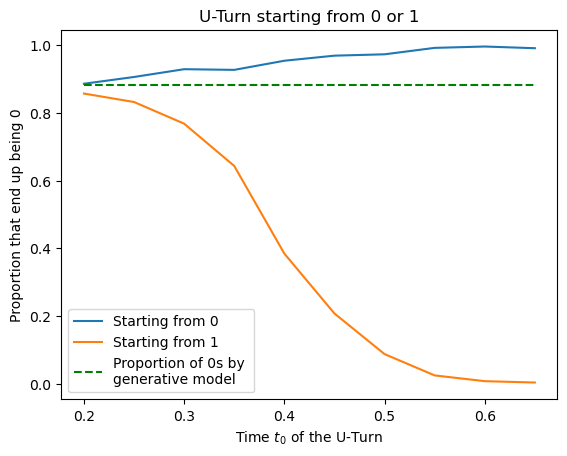

In [5]:
import numpy as np
import matplotlib.pyplot as plt
ts = np.arange(.35, .9, .05)
plt.plot(1-ts[:-1], [0.991, 0.996, 0.992, 0.973, 0.969, 0.954, 0.927, 0.929, 0.906, 0.886], label='Starting from 0')
plt.plot(1-ts[:-1], [0.003, 0.007, 0.024, 0.087, 0.207, 0.384, 0.643, 0.768, 0.832, 0.857], label='Starting from 1')
plt.axhline(.882, 0.045, .955, color='green', label='Proportion of 0s by \ngenerative model',linestyle='dashed')
plt.xlabel('Time $t_0$ of the U-Turn')
plt.ylabel('Proportion that end up being 0')
plt.title('U-Turn starting from 0 or 1')
plt.legend(loc='lower left')
plt.savefig('a.png')